<a href="https://colab.research.google.com/github/legalnlp21/legalnlp/blob/main/demo/Word2Vec/Compara%C3%A7%C3%A3o_W2V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicando o Word2Vec em um dataset para classificação

Nesse tutorial vamos demonstrar como utilizar word-embeddings geradas a partir do método Word2Vec, em cima de um corpo de texto, para classificação.

O método Word2Vec utiliza o contexto das palavras nos textos para gerar as embbedings. Para isso, foi utilizado o pacote *gensim* (versão 3.8.1), que integra as ferramentas necessárias para gerar, salvar e carregar as embbedings.

As ferramentas de limpeza de texto usadas foram criadas com o enfoque em textos do meio jurídico, mas podem ser usadas com outros textos igualmente. 

Para o funcionamento correto, recomendamos que o usuário tenha acesso aos seguintes módulos:
* ScikitLearn
* Keras
* Gensim
* String
* Numpy
* Pandas
* Ftfy

Neste tutorial, utilizamos um modelo de Redes Neurais Convolucionais para classificar processos legais em "Ativo", "Suspenso" e "Arquivado". O dataset esta disponível
[nesta página](https://www.kaggle.com/felipepolo/brazilian-legal-proceedings)
do Kaggle. \\
Este turorial foi baseados nos seguintes artigos 
[[3]](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/), [[4]](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/) e [[5]](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

In [1]:
from IPython.display import clear_output

!pip install gensim==3.8.1
!pip install git+https://github.com/legalnlp21/legalnlp
clear_output()

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

De início, vamos importar as bibliotecas e funções que serão usadas adiante. Devemos também instalar as bibliotecas que não estão disponíveis por padrão no Google Colab.

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

from string import punctuation

from os import listdir

from numpy import array
from numpy import asarray
from numpy import zeros

from gensim.models import KeyedVectors

from legalnlp.clean_functions import *
from legalnlp.get_premodel import get_premodel

clear_output()

In [5]:
# Downloading pre-trained model
get_premodel('w2vnilc')


True

In [19]:
model = KeyedVectors.load_word2vec_format('/content/cbow_s100/cbow_s100.txt')

## Carregando os dados

Vamos carregar a base de dados, que esta em formato *csv*.

In [20]:
df=pd.read_csv('https://raw.githubusercontent.com/legalnlp21/legalnlp/main/demo/data_base.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

,text,label
0,Início da Execução Juntado 0008003-11.2018.8.2...,H:Suspenso
1,Ofício Requisitório - Comunicação - Protocolo ...,H:Arquivado
2,Arquivado Provisoriamente aguardando manifestação,H:Suspenso
3,Petição Juntada Juntada a petição diversa - Ti...,H:Ativo
4,Remetidos os Autos para o Arquivo Geral – Devo...,H:Arquivado


In [21]:
df.shape

(6449, 2)

O dataset é composto por um conjunto de 6449 processos classificados nas 3 categorias:
* Ativo
* Suspenso
* Arquivado

Agora faremos a separação das categorias da nossa target, numerando de 0 a 2.

In [22]:
encoder = LabelEncoder()
encoder.fit(df['label'])
df['encoded'] = encoder.transform(df['label'])
df.drop(columns=['label'], inplace = True)
df

,text,encoded
0,Início da Execução Juntado 0008003-11.2018.8.2...,2
1,Ofício Requisitório - Comunicação - Protocolo ...,0
2,Arquivado Provisoriamente aguardando manifestação,2
3,Petição Juntada Juntada a petição diversa - Ti...,1
4,Remetidos os Autos para o Arquivo Geral – Devo...,0
...,...,...
6444,Remetidos os Autos para o Arquivo Geral – Devo...,2
6445,Certidão de Trânsito em Julgado com Baixa Expe...,0
6446,Petição Juntada Nº Protocolo: WSCB.19.70085805...,1
6447,Remetidos os Autos para o Tribunal de Justiça/...,1


In [23]:
X_textos = df['text'].apply(clean)
X_textos.head(5)

0    início da execução juntado [processo] - - cump...
1    ofício requisitório - - comunicação - - protoc...
2    arquivado provisoriamente aguardando manifestação
3    petição juntada juntada a petição diversa - - ...
4    remetidos os autos para o arquivo geral – devo...
Name: text, dtype: object

In [24]:
labels = np.array(df['encoded'])
labels[:5]

array([2, 0, 2, 1, 0])

Com isso feito, podemos tratar nossos dados para que a rede possa interpreta-los e trabalhar de forma adequada.

## Preparando os dados

O dataset que estamos usando não precisou de muito tratamento. Para as próprias aplicações, o leitor deve verificar com cautela as peculiaridades dos dados, antes de realizar a tokenização.

Com nossos textos tratados, vamos começar a prepará-los para serem recebidos pela rede neural. A estrutura basica da rede neural para NLP deve iniciar com uma camada chamada de "embedding layer". Essa camada é a responsável por traduzir as palavras para vetores. Ela fara isso a partir de uma matriz de pesos, onde cada i-ésima linha contém o vetor referente a i-ésima palavra.

Portanto, devemos indexar cada tokem a um número natural, e representar nossos textos como vetores de indexação, ou seja, vetores com os números inteiros referentes a cada palavra. Para isso vamos tokenizar nosso corpo de texto utilizando o objeto *Tokenizer* do Keras. 

In [25]:
t = Tokenizer()
t.fit_on_texts(X_textos)
tamanho_vocab = len(t.word_index) + 1
encoded_textos = array(t.texts_to_sequences(X_textos))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [26]:
t.index_word[122], t.index_word[5], t.index_word[69], t.index_word[59], t.index_word[34], t.index_word[76], "..."

('início', 'da', 'execução', 'juntado', 'processo', 'cumprimento', '...')

In [27]:
print(encoded_textos[0])

[122, 5, 69, 59, 34, 76, 2, 56]


Cada vetor agora representa um texto, contúdo, cada um pode ter tamanhos distintos. Devemos padroniza-los, aplicando *zero-padding.*

In [28]:
len_maior = 0
for lista in encoded_textos:
  if len(lista) > len_maior: len_maior = len(lista)

len_maior

306

Vamos usar a função "pad_sequences" do Keras para ajustar o tamanho dos textos para 306. Além disso, é recomendável que passemos os índices para "float".

In [29]:
padded_docs = pad_sequences(encoded_textos, maxlen=len_maior, padding='post').astype('float32')

len(padded_docs[0])

306

Nossos textos estão prontos para serem recebidos pela rede neural, contudo, ainda é necessário gerar a camada de embbeding da rede. Faremos isso na próxima seção.

Também devemos tratar o nosso vetor de categorias. Por padrão, nossa target deve estar em formato matricial, com 1 na coluna representante da categoria do texto daquela linha e 0 nas demais.

Vamos usar o objeto "OneHotEncoder" do ScikitLearn e passar a matriz para a forma densa (objeto retorna na forma de matriz esparça). 

In [30]:
encoder = OneHotEncoder(handle_unknown='ignore')
label_onehot = encoder.fit_transform(labels.reshape((-1,1))).todense()

label_onehot[:3]

matrix([[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]])

Agora, com nossos dados preparados, começaremos a cuidar da "embbeding layer". 

## Preparando as embeddings

Com o modelo carregado, já podemos estruturar a matriz de pesos. Neste caso específico, todas as palavras do corpo de texto dos dados estão contidas no vocabulário do modelo Word2Vec, contudo, o leitor deve ter o cuidado de tratar os casos em que essa equivalência não aconteça.

Vamos estruturar um dicionário, no qual cada chave é uma palavra do corpo do vocabulário do modelo e cada valor representa sua embbeding.

In [31]:
wv_dict = dict(zip(model.wv.index2word[:], model.wv.vectors[:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Para acelerar o treino da rede, e diminuir o tamanho da matriz de pesos, podemos fazer um dicionário somente com as palavras do *corpus*, pois geralmente, o vocabulário do modelo *pre-trained Word2Vec* é muito mais extenso que o necessário. 

In [32]:
wv_dict_updated = {}
for palavra in t.index_word.values():
  if palavra in wv_dict.keys():
    wv_dict_updated[palavra] = wv_dict[palavra]

Por fim, podemos estruturar a matriz de pesos, colocando a palavra de i-ésimo índice na i-ésima linha da matriz.

In [33]:
matriz_de_pesos = zeros((tamanho_vocab, 100))
for palavra, i in t.word_index.items():
  vetor_embed =  wv_dict_updated.get(palavra)
  if vetor_embed is not None:
    matriz_de_pesos[i] = vetor_embed

matriz_de_pesos.shape

(2827, 100)

## Treinando o modelo

Com nossos dados codificados, e nossa matriz de pesos pronta, podemos começar a estruturar nossa Rede Neural. Nosso modelo será uma Rede Neural Convolucional, ou seja, aplicaremos uma camada de filtragem e em seguida uma camada de *pooling*, buscando ressaltar informações importantes das *embbedings*. 

Nossa rede terá a seguinte estrutura:
1. A primeira camada de *embbeding*, que fara a codificação das palavras (representadas como índices) nos seus respectivos vetores.
2. A segunda será uma camada convolucional, com 128 filtros no output, *kernel* de tamanho 5 e função de ativação 'ReLU'.
3. A terceira camada será a *MaxPooling* de tamanho 2.
4. Como o output da 3ª camada é um tensor, a quarta camada será uma camada de "achatamento".
5. Por fim, a camada do output, de tamanho 3 e função de ativação *softmax*.

In [34]:
emb = Embedding(tamanho_vocab, 100, weights = [matriz_de_pesos], input_length=len_maior, trainable = False)

rede = Sequential()

rede.add(emb)
rede.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
rede.add(MaxPooling1D(pool_size=2))
rede.add(Flatten())
rede.add(Dense(3, activation='softmax'))

Para terminar a estrutura da rede, vamos usar a função perda como 'categorical_crossentropy', o caso categórico da entropia cruzda, para o otimizador ultilizaremos o 'adam' e a métrica de avaliação será a acurácia. Podemos ver a arquitetura utilizando o método "*Sequential().summary()*".

In [35]:
rede.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(rede.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 306, 100)          282700    
_________________________________________________________________
conv1d (Conv1D)              (None, 302, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 151, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 19328)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 57987     
Total params: 404,815
Trainable params: 122,115
Non-trainable params: 282,700
_________________________________________________________________
None


Vamos separar nossos dados em dados de treino e teste.

In [36]:
X_treino, X_teste, y_treino, y_teste = train_test_split(padded_docs, label_onehot, random_state=42, train_size=0.7, test_size=0.3)

Por fim, podemos treinar o modelo e verificar nossos resultados. 

In [37]:
rede.fit(X_treino, y_treino, epochs=50, validation_split=0.1, batch_size=500, verbose=1,  callbacks=[EarlyStopping(monitor='val_loss', patience=15)])

Epoch 1/50
9/9 [==============================] - 11s 1s/step - loss: 0.9121 - accuracy: 0.5739 - val_loss: 0.7720 - val_accuracy: 0.7345
Epoch 2/50
9/9 [==============================] - 12s 1s/step - loss: 0.7628 - accuracy: 0.6962 - val_loss: 0.6878 - val_accuracy: 0.7389
Epoch 3/50
9/9 [==============================] - 9s 1s/step - loss: 0.6741 - accuracy: 0.7226 - val_loss: 0.6362 - val_accuracy: 0.7500
Epoch 4/50
9/9 [==============================] - 9s 1s/step - loss: 0.6226 - accuracy: 0.7393 - val_loss: 0.5866 - val_accuracy: 0.7765
Epoch 5/50
9/9 [==============================] - 9s 979ms/step - loss: 0.5831 - accuracy: 0.7706 - val_loss: 0.5487 - val_accuracy: 0.8031
Epoch 6/50
9/9 [==============================] - 9s 982ms/step - loss: 0.5446 - accuracy: 0.7890 - val_loss: 0.5184 - val_accuracy: 0.8164
Epoch 7/50
9/9 [==============================] - 9s 960ms/step - loss: 0.5153 - accuracy: 0.7964 - val_loss: 0.5055 - val_accuracy: 0.8164
Epoch 8/50
9/9 [==============

In [38]:
loss, acc_treino = rede.evaluate(X_treino, y_treino, verbose=0)
loss2, acc_teste = rede.evaluate(X_teste, y_teste, verbose=0)
print(f'Acurácia no treino: {round(acc_treino*100, 2)}%')
print(f'Acurácia no teste: {round(acc_teste*100, 2)}%')

Acurácia no treino: 88.97%
Acurácia no teste: 83.98%


In [39]:
predict = rede.predict(X_teste)

In [40]:
predict1 = np.argmax(predict, axis=1)

y_teste1 = np.argmax(y_teste, axis=1)
np.array(y_teste1.reshape(1,-1))[0]

array([2, 1, 1, ..., 1, 0, 1])

In [41]:
print(classification_report(y_teste1, predict1, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       923
           1       0.84      0.85      0.84       864
           2       0.90      0.60      0.72       148

    accuracy                           0.84      1935
   macro avg       0.86      0.77      0.81      1935
weighted avg       0.84      0.84      0.84      1935



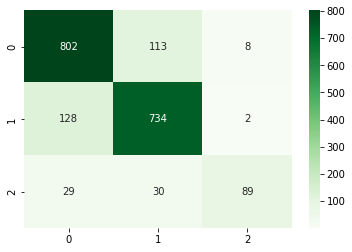

In [42]:
cm = confusion_matrix(y_teste1, predict1)
sns.heatmap(cm , fmt=".3g", annot= True, cmap="Greens")

plt.show()

#Referências

[1] Mikolov, T., Chen, K., Corrado, G., and Dean, J. (2013a).  Efficient estimation ofword representations in vector space.arXiv preprint arXiv:1301.3781. \\
[2] Mikolov,  T.,  Sutskever,  I.,  Chen,  K.,  Corrado,  G. S.,  and Dean,  J. (2013b).   Distributed representations of words and phrases and their compositionality.  In Advances in neural information processing systems, pages 3111–3119. \\
[3] Brownlee Jason(2017). https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/ - acesso em: 04/08/2021.  \\
[4] Brownlee Jason(2017). https://machinelearningmastery.com/best-practices-document-classification-deep-learning/ - acesso em: 04/08/2021.  \\
[5] Brownlee Jason(2017). https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/ - acesso em: 04/08/2021. \\